---
title: "Forward Simulation of 3D Airborne FDEM Data on a Tree Mesh"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed 15 minutes and/or require up to 8 GB of available RAM.
```

**Keywords:** FDEM, 3D forward simulation, tree mesh.

</br>

**Summary:** In this tutorial, we present the fundamentals of simulating 3D FDEM data in SimPEG. We use the module [simpeg.electromagnetics.static.frequency_domain](myst:simpeg#simpeg.electromagnetics.frequency_domain) to simulate airborne FDEM data on a tree mesh. We assume the reader is already familiar with the fundamental aspects of simulating FDEM data in SimPEG, which were covered in the [Forward Simulation of Frequency Domain EM Data for a 1D Sounding](fwd_fdem_1d.ipynb) tutorial. This tutorial focusses on the following:

- Defining FDEM surveys for 3D simulations
- How to define an appropriate tree mesh based on problem geometry
- Defining models and mappings for simulation on a tree mesh
- Including surface topography in the simulation
- Choosing a 3D formulation that works best for the geometry of the problem
- Accurately simulating total field and secondary field FDEM data

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to FDEM is imported from [simpeg.electromagnetics.frequency_domain](myst:simpeg#simpeg.electromagnetics.frequency_domain). 
We also import some useful utility functions from [simpeg.utils](myst:simpeg#simpeg.utils). And to generate the mesh, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
import simpeg.electromagnetics.frequency_domain as fdem
from simpeg.utils import plot2Ddata
from simpeg import maps

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})

save_file = False

## Defining Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) for 3D simulations.
To keep things simple, we create flat topography for the forward simulation.
For user-specific simulations, you may generate less trivial topography or load topography from an XYZ file.

In [2]:
x_topo, y_topo = np.meshgrid(
    np.linspace(-3000, 3000, 101), np.linspace(-3000, 3000, 101)
)
z_topo = np.zeros(np.shape(x_topo))

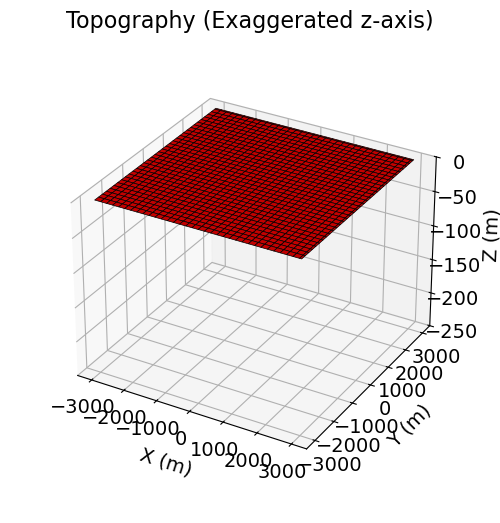

In [3]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-250, 0])
ax.plot_surface(x_topo, y_topo, z_topo, color="r", edgecolor="k", linewidth=0.5)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=30.0)

In [4]:
# Turn into a (N, 3) numpy.ndarray
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

## Defining the Survey

The fundamentals of constructing FDEM surveys was presented in the [Forward Simulation of Frequency Domain EM Data for a 1D Sounding](fwd_fdem_1d.ipynb) tutorial. We advise the reader to already be familiar with this material. For a full description of all source and receiver classes, please visit API documentation for [simpeg.electromagnetics.frequency_domain](myst:simpeg#simpeg.electromagnetics.frequency_domain).

**For this tutorial**, we simulate data for a [DIGHEM survey geometry](https://em.geosci.xyz/content/geophysical_surveys/airborne_fdem/dighem.html). This surveys is ideal for demonstrating the general construction of FDEM survey within SimPEG because there are a multitude of data locations and source-receiver geometries; i.e. vertical coplanar and horizontal coaxial. Here, the airborne survey consists of an 9x9 grid with a spacing of 50 m. The transmitter-receiver separation is in the x-direction and the flight height is 20 m. And the location of the datum is defined at the source location.

In [5]:
# Frequencies being predicted
frequencies = [1000.0, 5000.0, 25000.0]  # in Hz

# Tx-Rx separations (along-x)
separation = 10.0

In [6]:
# Defining data locations
N = 15
xloc, yloc, zloc = np.meshgrid(
    np.linspace(-175, 175, N), np.linspace(-175, 175, N), [22.5]
)
data_locations = np.c_[mkvc(xloc), mkvc(yloc), mkvc(zloc)]

In [7]:
n_freq = len(frequencies)  # Number of source types
n_locs = np.shape(data_locations)[0]  # Number of locations
source_list = []  # Create empty list to store sources

# Loop over all source geometries/frequencies
for f in frequencies:
    # Loop over data locations
    for jj in range(n_locs):
        # Apply separation to get receiver location
        source_location = data_locations[jj, :] - np.r_[separation / 2, 0.0, 0.0]
        receiver_location = data_locations[jj, :] + np.r_[separation / 2, 0.0, 0.0]

        # Define the receivers for the given source
        bzr_receiver = fdem.receivers.PointMagneticFluxDensity(
            #         bzr_receiver = fdem.receivers.PointMagneticField(
            receiver_location,
            orientation="z",
            component="real",
            data_type="field",
        )
        bzi_receiver = fdem.receivers.PointMagneticFluxDensity(
            #         bzi_receiver = fdem.receivers.PointMagneticField(
            receiver_location,
            orientation="z",
            component="imag",
            data_type="field",
        )
        receivers_list = [bzr_receiver, bzi_receiver]

        # Define the source and connect the associated receivers
        #         source_list.append(
        #             fdem.sources.MagDipole(
        #                 receivers_list,
        #                 f,
        #                 source_location,
        #                 orientation='z'
        #             )
        #         )
        source_list.append(
            fdem.sources.CircularLoop(receivers_list, f, source_location, radius=1)
        )

# Define the survey object
survey = fdem.Survey(source_list)

## Designing a (Tree) Mesh for FDEM

Meshes are designed using the [discretize](https://discretize.simpeg.xyz/en/main) package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes.
Here, the forward simulation is computed for a [tree mesh](myst:discretize#discretize.TreeMesh). Because of the modular nature of SimPEG, you could define a [tensor mesh](myst:discretize#discretize.TensorMesh) instead.

### General Approach:

The primary electromagnetic fields produced by controlled sources fall off very quickly with respect to distance. For example, the primary magnetic field produced by a magnetic dipole source falls off as $r^{-3}$. Because the amplitude and direction of the primary fields varies greatly close to the source, smaller cells are needed there to model the fields accurately. Far away from the source, larger cells can be used since the fields are much smoother. Tree meshes are well-suited for FDEM simulations because the cell size can be increased at specified distances from controlled sources. For any controlled source FDEM simulation, we advise the following considerations and rules of thumb:

1. The smallest cell size used to discretize the Earth should be at most 1/4 of the skin depth at the highest frequency.
2. To impose the boundary conditions properly, the padding thickness should be at least 2-3 times the skin depth for the lowest operating frequency and background conductivity. You must also pad upwards into the air.
3. Successive increases in cell size should not happen too abruptly. Within your volume of interest, you should have 4 layers of cells of the same size before increasing the cell size.
4. You need to have several cells between the source and receiver in order to simulate the primary signal accurately.
5. Finer discretization is required when topography is significant.

**Important:** because the skin depth depends on both frequency and electrical conductivity, we must know something about the subsurface physical properties as well as the survey properties prior to designing our mesh.

### Tutorial Example:

For the tutorial example, we have a more conductive block (0.01 S/m) in a fairly resistive halfspace (0.0005 S/m). From the survey design section of the tutorial, we know that our source used operating frequencies of 900 Hz, 1000 Hz, 5500 Hz, 7000 Hz, and 56000 Hz. Our first step is to compute the skin depths at the highest frequency, where:

$$
\delta_{min}(\sigma=0.0005) \approx 500 \sqrt{\frac{1}{\sigma \, f_{max}}} \approx 32 m
$$

and

$$
\delta_{min}(\sigma=0.01) \approx 500 \sqrt{\frac{1}{\sigma \, f_{max}}} \approx 100 m
$$

As we can see, the minimum cell size required to discretize the background is much larger than that for the conductor. Next we compute the skin depth for the lowest operating frequency and background conductivity, where:

$$
\delta_{max}(\sigma=0.0005) \approx 500 \sqrt{\frac{1}{\sigma \, f_{min}}} \approx 500 m
$$

For the tutorial example, we chose to use the following discretization

- A cell size of 2.5 meters was used immediately near the sources. This is because the minimum source-receiver spacing was 6.3 m. We are unlikely to model the primary signal accurately, but we will demonstrate further on how secondary field data can be modeled accurately.
- A minimum cells size of 10 m was used to discretize the Earth. We expect the inductive response from the host to be accurate at all frequencies. However, the inductive response from the conductive target may not be particularly accurate at the highest frequency.
- The width of the domain in the x, y and z direction was chosen to be 4000 m. As a result, the padding (~2000 m) is roughly 2-3 times the largest skin depth.

Using the [refine_surface](myst:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. And using the [refine_points](myst:discretize#discretize.TreeMesh.refine_points) methods, we refine based on electrodes locations. Visit the [tree mesh](myst:discretize#discretize.TreeMesh) API to see additional refinement methods.

In [8]:
# Define the base mesh
dh = 5.0  # base cell width
dom_width = 3000.0  # domain width
nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

h = [(dh, nbc)]
mesh = TreeMesh([h, h, h], x0="CCC")

# Mesh refinement based on surface topography (starting with 20 cells)
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 400
mesh.refine_surface(
    topo_xyz[k, :], level=-3, padding_cells_by_level=[2, 4], finalize=False
)

# Mesh refinement near controlled sources (starting with 2.5 m cells)
source_locations = data_locations - np.r_[separation / 2, 0.0, 0.0]
mesh.refine_points(
    source_locations, level=-1, padding_cells_by_level=[3, 2, 2], finalize=False
)

# Refine core mesh region (starting with 10 m cells)
xp, yp, zp = np.meshgrid([-280.0, 280.0], [-280.0, 280.0], [-80.0, 20.0])
box_points = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
mesh.refine_bounding_box(
    box_points, level=-2, padding_cells_by_level=[0, 4, 4, 4], finalize=False
)

# Finalize the mesh
mesh.finalize()

In [9]:
print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 115088
# of x-faces: 113094
Origin: [-1280. -1280. -1280.]
Max cell volume: 32768000.0
[[-1120. -1120. -1120.]
 [ -800. -1120. -1120.]
 [-1120.  -800. -1120.]
 [ -800.  -800. -1120.]
 [-1120. -1120.  -800.]]


## Active Cells

Simulated geophysical data are dependent on the subsurface distribution of physical property values. As a result, the cells lying below the surface topography are commonly referred to as 'active cells'. And air cells, whose physical property values are fixed, are commonly referred to as 'inactive cells'. Here, the discretize [active_from_xyz](myst:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [10]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
ind_active = active_from_xyz(mesh, topo_xyz)
nP = np.sum(ind_active)  # number of parameters

## Models and Mapping from the Model to the Mesh

In SimPEG, the term 'model' is not necessarily synonymous with the set of physical property values defined on the mesh. For example, the model may be defined as the logarithms of the physical property values, or be the parameters defining a layered Earth geometry. Models in SimPEG are 1D [numpy.ndarray](myst:numpy#numpy.ndarray) whose lengths are
equal to the number of model parameters.

Classes within the [simpeg.maps](myst:simpeg#simpeg.maps.IdentityMap) module are used to define the mapping that connects the model to the physical property values used in the 3D FDEM simulation. Sophisticated mappings can be defined by combining multiple mapping objects. But in the simplest case, the mapping is an identity map and the model consists of the conductivity/resistivity values for all mesh cells (including air). Here, the model consists of the log-conductivity values for all active mesh cells.

When simulating 3D FDEM data, we have the choice of using resistivity or conductivity to define the Earth's electrical properties. However, one option may be implemented more naturally depending on the formulation used.

### Defining the Model

In [11]:
# Define conductivity values in S/m (or resistivity in Ohm m)
air_conductivity = 1e-8
background_conductivity = 0.001
block_conductivity = 0.01

In [12]:
# Define conductivities on active cells
active_conductivities = background_conductivity * np.ones(nP)
ind_block = (
    (mesh.cell_centers[ind_active, 0] < 80.0)
    & (mesh.cell_centers[ind_active, 0] > -80.0)
    & (mesh.cell_centers[ind_active, 1] < 80.0)
    & (mesh.cell_centers[ind_active, 1] > -80.0)
    & (mesh.cell_centers[ind_active, 2] > -120.0)
    & (mesh.cell_centers[ind_active, 2] < -30.0)
)
active_conductivities[ind_block] = block_conductivity

In [13]:
# Define the log-conductivity model
log_conductivity_model = np.log(active_conductivities)

### Defining the Mapping

Here, we use the [simpeg.maps.ExpMap](myst:simpeg#simpeg.maps.ExpMap) mapping to convert our model values from log-conductivities to conductivities, and the [simpeg.maps.InjectActiveCells](myst:simpeg#simpeg.maps.InjectActiveCells) mapping to project active cells to the entire mesh. As we will demonstrate, a single mapping can be constructed from multiple mapping classes using the $*$ operator. **Important:** When defining the active cells mapping, we set all inactive (air) cells to 1e-8 $S/m$ instead of $0$. This is done to ensure that the linear system constructed to solve the PDE for the DC resistivity problem is well-conditioned.

In [14]:
log_conductivity_map = maps.InjectActiveCells(
    mesh, ind_active, air_conductivity
) * maps.ExpMap(nP=nP)

### Plotting the discretization and active conductivities

To show the geometry of the problem, we plot the discretization near several sources and the active cell conductivities using the [plot_slice](myst:discretize#discretize.TreeMesh.plot_slice) method.

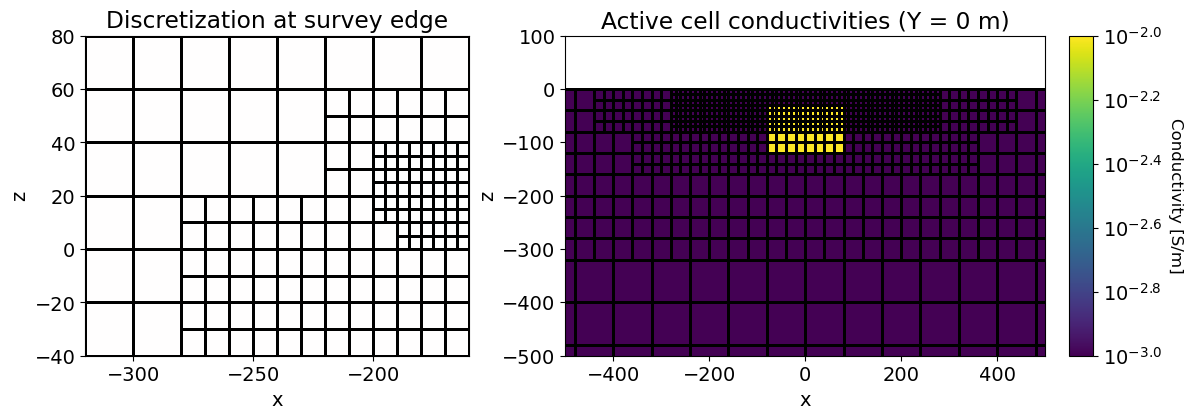

In [15]:
fig = plt.figure(figsize=(12, 4))

# Plot discretization near source
ax1 = fig.add_axes([0.05, 0.1, 0.32, 0.8])
mesh.plot_slice(
    np.zeros(mesh.nC),
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[0].size / 2),
    grid=True,
    clim=[-1, 1],
    pcolor_opts={"cmap": mpl.cm.bwr},
)
ax1.set_xlim([-320, -160])
ax1.set_ylim([-40, 80])
ax1.set_title("Discretization at survey edge")

# Plot active cell conductivities
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
log10_conductivities = np.log10(active_conductivities)
norm = mpl.colors.Normalize(
    vmin=np.log10(background_conductivity), vmax=np.log10(block_conductivity)
)

ax2 = fig.add_axes([0.45, 0.1, 0.4, 0.8])
mesh.plot_slice(
    plotting_map * log10_conductivities,
    normal="Y",
    ax=ax2,
    ind=int(mesh.h[0].size / 2),
    grid=True,
    pcolor_opts={"norm": norm},
)
ax2.set_xlim([-500, 500])
ax2.set_ylim([-500, 100])
ax2.set_title("Active cell conductivities (Y = 0 m)")

cax2 = fig.add_axes([0.87, 0.1, 0.02, 0.8])

cbar = mpl.colorbar.ColorbarBase(
    cax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

## Defining the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- the mapping from the model to the mesh

This is accomplished by setting each one of the aforementioned items as a property of the simulation object. Here, we define two simulation objects, one where the model defines the subsurface conductivities, and one where the model defines subsurface log-resistivities. When our model is used to define subsurface electric conductivity, the mapping is set using the ``sigmaMap`` keyword argument. However when our model is used to define subsurface electric resistivity, the mapping must be set using the ``rhoMap`` keyword argument.

### Choosing a formulation

There are a multitude of simulation classes, each of which solves Maxwell's equations in terms of a different field:

- [Simulation3DElectricField](myst:simpeg#simpeg.electromagnetics.frequency_domain.Simulation3DElectricField), which solves for the electric fields on mesh edges.
- [Simulation3DMagneticFluxDensity](myst:simpeg#simpeg.electromagnetics.frequency_domain.Simulation3DMagneticFluxDensity), which solves for the magnetic flux density on mesh faces.
- [Simulation3DMagneticField](myst:simpeg#simpeg.electromagnetics.frequency_domain.Simulation3DMagneticField), which solves for the magnetic fields on mesh edges.
- [Simulation3DCurrentDensity](myst:simpeg#simpeg.electromagnetics.frequency_domain.Simulation3DCurrentDensity), which solves for the current density on mesh faces.

The optimum choice in simulation class depends on the fields being measured and the class used to define FDEM sources. For example, it may be best to use the electric field formulation when the source is a line-current and electric fields are being measured. And it may be best to use the magnetic field formulation for a magnetic dipole source and magnetic field measurements.

### Practical considerations

For each unique operating frequency, we need to factor the

For each source

Mesh size

In [16]:
simulation = fdem.simulation.Simulation3DElectricField(
    mesh, survey=survey, sigmaMap=log_conductivity_map, forward_only=True
)

# simulation = fdem.simulation.Simulation3DMagneticField(
#     mesh, survey=survey, sigmaMap=log_conductivity_map, forward_only=True
# )

## Simulating Total Field and Secondary Field Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](myst:simpeg#simpeg.simulation.BaseSimulation.dpred) method. Note that despite the difference in how we defined the models representing the Earth's electrical properties, the data predicted by both simulations is equivalent.

In [17]:
dpred_primary = simulation.dpred(np.log(1e-8) * np.ones_like(log_conductivity_model))

In [18]:
dpred_total = simulation.dpred(log_conductivity_model)

In [19]:
dpred_sorted = np.reshape(dpred_total - dpred_primary, (n_freq, n_locs, 2), order="C")

### Plotting total field data for HCP geometry at 900 Hz

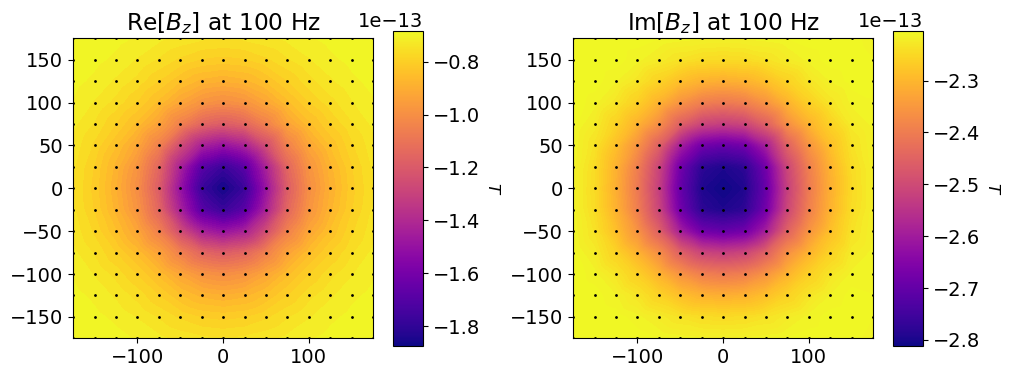

In [20]:
txid = -1

fig = plt.figure(figsize=(10, 3.5))

ax1 = fig.add_axes([0.05, 0.05, 0.3, 0.9])
min_val = np.min(dpred_sorted[txid, :, 0::2])
max_val = np.max(dpred_sorted[txid, :, 0::2])
norm1 = mpl.colors.Normalize(min_val, max_val)

plot2Ddata(
    data_locations[:, 0:2],
    dpred_sorted[txid, :, 0],
    dataloc=True,
    ax=ax1,
    ncontour=50,
    contourOpts={"cmap": "plasma", "norm": norm1},
)
ax1.set_title("Re[$B_z$] at 100 Hz")

cax1 = fig.add_axes([0.37, 0.05, 0.03, 0.9])
cbar1 = mpl.colorbar.ColorbarBase(
    cax1, norm=norm1, orientation="vertical", cmap=mpl.cm.plasma
)
cbar1.set_label("$T$", rotation=270, labelpad=15, size=12)

# Imaginary Component
ax2 = fig.add_axes([0.55, 0.05, 0.3, 0.9])
min_val = np.min(dpred_sorted[txid, :, 1::2])
max_val = np.max(dpred_sorted[txid, :, 1::2])
norm2 = mpl.colors.Normalize(min_val, max_val)

plot2Ddata(
    data_locations[:, 0:2],
    dpred_sorted[txid, :, 1],
    dataloc=True,
    ax=ax2,
    ncontour=100,
    contourOpts={"cmap": "plasma", "norm": norm2},
)
ax2.set_title("Im[$B_z$] at 100 Hz")

cax2 = fig.add_axes([0.87, 0.05, 0.03, 0.9])
cbar2 = mpl.colorbar.ColorbarBase(
    cax2, norm=norm2, orientation="vertical", cmap=mpl.cm.plasma
)
cbar2.set_label("$T$", rotation=270, labelpad=15, size=12)

plt.show()

## Optional: Export Data

Write the true model, data and topography




In [21]:
if save_file:
    dir_path = os.path.dirname(fdem.__file__).split(os.path.sep)[:-3]
    dir_path.extend(["tutorials", "assets", "fdem"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    # Write topography
    fname = dir_path + "fdem_topo.txt"
    np.savetxt(fname, np.c_[topo_xyz], fmt="%.4e")

    # Write data with 2% noise added
    fname = dir_path + "fdem_data.obs"
    bz_real = bz_real + 1e-14 * np.random.rand(len(bz_real))
    bz_imag = bz_imag + 1e-14 * np.random.rand(len(bz_imag))
    f_vec = np.kron(frequencies, np.ones(ntx))
    receiver_locations = np.kron(np.ones((len(frequencies), 1)), receiver_locations)

    np.savetxt(fname, np.c_[f_vec, receiver_locations, bz_real, bz_imag], fmt="%.4e")

    # Plot true model
    output_model = plotting_map * model
    output_model[np.isnan(output_model)] = 1e-8

    fname = dir_path + "true_model.txt"
    np.savetxt(fname, output_model, fmt="%.4e")